Image Denoising

In [ ]:
! git clone https://github.com/tejaslambat03/ImageCleaning.git
%cd ./ImageCleaning

Cloning into 'ImageCleaning'...
remote: Enumerating objects: 527, done.
remote: Counting objects: 100% (527/527), done.
remote: Compressing objects: 100% (236/236), done.
remote: Total 527 (delta 280), reused 518 (delta 276), pack-reused 0
Receiving objects: 100% (527/527), 16.19 MiB | 32.25 MiB/s, done.
Resolving deltas: 100% (280/280), done.
/content/ImageCleaning


## Set up the enviroment

In [ ]:
!pip install -r requirements.txt
!pip install --upgrade --no-cache-dir gdown
!python3 setup.py develop --no_cuda_ext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 16.0 MB/s eta 0:00:00
  Attempting uninstall: gdown
    Found existing installation: gdown 4.7.3
    Uninstalling gdown-4.7.3:
      Successfully uninstalled gdown-4.7.3
/usr/local/lib/python3.10/dist-packages/setuptools/__init__.py:84: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
!!

        ********************************************************************************
        Requirements should be satisfied by a PEP 517 installer.
        If you are using pip, you can try `pip install --use-pep517`.
        ********************************************************************************

!!
  dist.fetch_build_eggs(dist.setup_requires)
running develop
/usr/local/lib/python3.10/dist-packages/setuptools/command/develop.py:40: EasyI

## Download pretrained models

In [ ]:
import gdown
gdown.download('https://drive.google.com/uc?id=14Fht1QQJ2gMlk4N1ERCRuElg8JfjrWWR', "./experiments/pretrained_models/", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=14Fht1QQJ2gMlk4N1ERCRuElg8JfjrWWR
From (redirected): https://drive.google.com/uc?id=14Fht1QQJ2gMlk4N1ERCRuElg8JfjrWWR&confirm=t&uuid=0cf23fe5-d6e2-4065-bc79-f764eb0ba1d7
To: /content/ImageCleaning/experiments/pretrained_models/NAFNet-SIDD-width64.pth
100%|██████████| 464M/464M [00:04<00:00, 106MB/s] 


'./experiments/pretrained_models/NAFNet-SIDD-width64.pth'

## Download Demo Image

In [ ]:
gdown.download('https://drive.google.com/uc?id=1uKwZUgeGfBYLlPKllSuzgGUItlzb40hm', "demo_input/", quiet=False)
gdown.download('https://drive.google.com/uc?id=1ov6UqpIA6GjjJT5SdGeUAJECxka14nGf', "demo_input/", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1uKwZUgeGfBYLlPKllSuzgGUItlzb40hm
To: /content/ImageCleaning/demo_input/noisy-demo-0.png
100%|██████████| 171k/171k [00:00<00:00, 51.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ov6UqpIA6GjjJT5SdGeUAJECxka14nGf
To: /content/ImageCleaning/demo_input/noisy-demo-1.png
100%|██████████| 150k/150k [00:00<00:00, 65.3MB/s]


'demo_input/noisy-demo-1.png'

## Preparation

In [ ]:
import torch

from basicsr.models import create_model
from basicsr.utils import img2tensor as _img2tensor, tensor2img, imwrite
from basicsr.utils.options import parse
import numpy as np
import cv2
import matplotlib.pyplot as plt

def imread(img_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img
def img2tensor(img, bgr2rgb=False, float32=True):
    img = img.astype(np.float32) / 255.
    return _img2tensor(img, bgr2rgb=bgr2rgb, float32=float32)

def display(img1, img2):
  fig = plt.figure(figsize=(25, 10))
  ax1 = fig.add_subplot(1, 2, 1)
  plt.title('Original Image', fontsize=16)
  ax1.axis('off')
  ax2 = fig.add_subplot(1, 2, 2)
  plt.title('Denoised Image', fontsize=16)
  ax2.axis('off')
  ax1.imshow(img1)
  ax2.imshow(img2)

def single_image_inference(model, img, save_path):
      model.feed_data(data={'lq': img.unsqueeze(dim=0)})

      if model.opt['val'].get('grids', False):
          model.grids()

      model.test()

      if model.opt['val'].get('grids', False):
          model.grids_inverse()

      visuals = model.get_current_visuals()
      sr_img = tensor2img([visuals['result']])
      imwrite(sr_img, save_path)


## Create Model

In [ ]:
opt_path = 'options/test/SIDD/NAFNet-width64.yml'
opt = parse(opt_path, is_train=False)
opt['dist'] = False
NAFNet = create_model(opt)

 load net keys <built-in method keys of collections.OrderedDict object at 0x7824c9c9dac0>


# Inference and Show results

# Try it on uploaded images

## 1. Upload images

In [ ]:
import os
from google.colab import files
import shutil

upload_folder = 'upload/input'
result_folder = 'upload/output'

if os.path.isdir(upload_folder):
    shutil.rmtree(upload_folder)
if os.path.isdir(result_folder):
    shutil.rmtree(result_folder)
os.makedirs(upload_folder)
os.makedirs(result_folder)

# upload images
uploaded = files.upload()
for filename in uploaded.keys():
  dst_path = os.path.join(upload_folder, filename)
  print(f'move {filename} to {dst_path}')
  shutil.move(filename, dst_path)

Saving image (1).jpg to image (1).jpg
move image (1).jpg to upload/input/image (1).jpg


## Inference

In [ ]:
import glob
from calculation import accuracy
input_list = sorted(glob.glob(os.path.join(upload_folder, '*')))
for input_path in input_list:
  img_input = imread(input_path)
  inp = img2tensor(img_input)
  output_path = os.path.join(result_folder, os.path.basename(input_path))
  single_image_inference(NAFNet, inp, output_path)

## 3. Visualize (Optional)

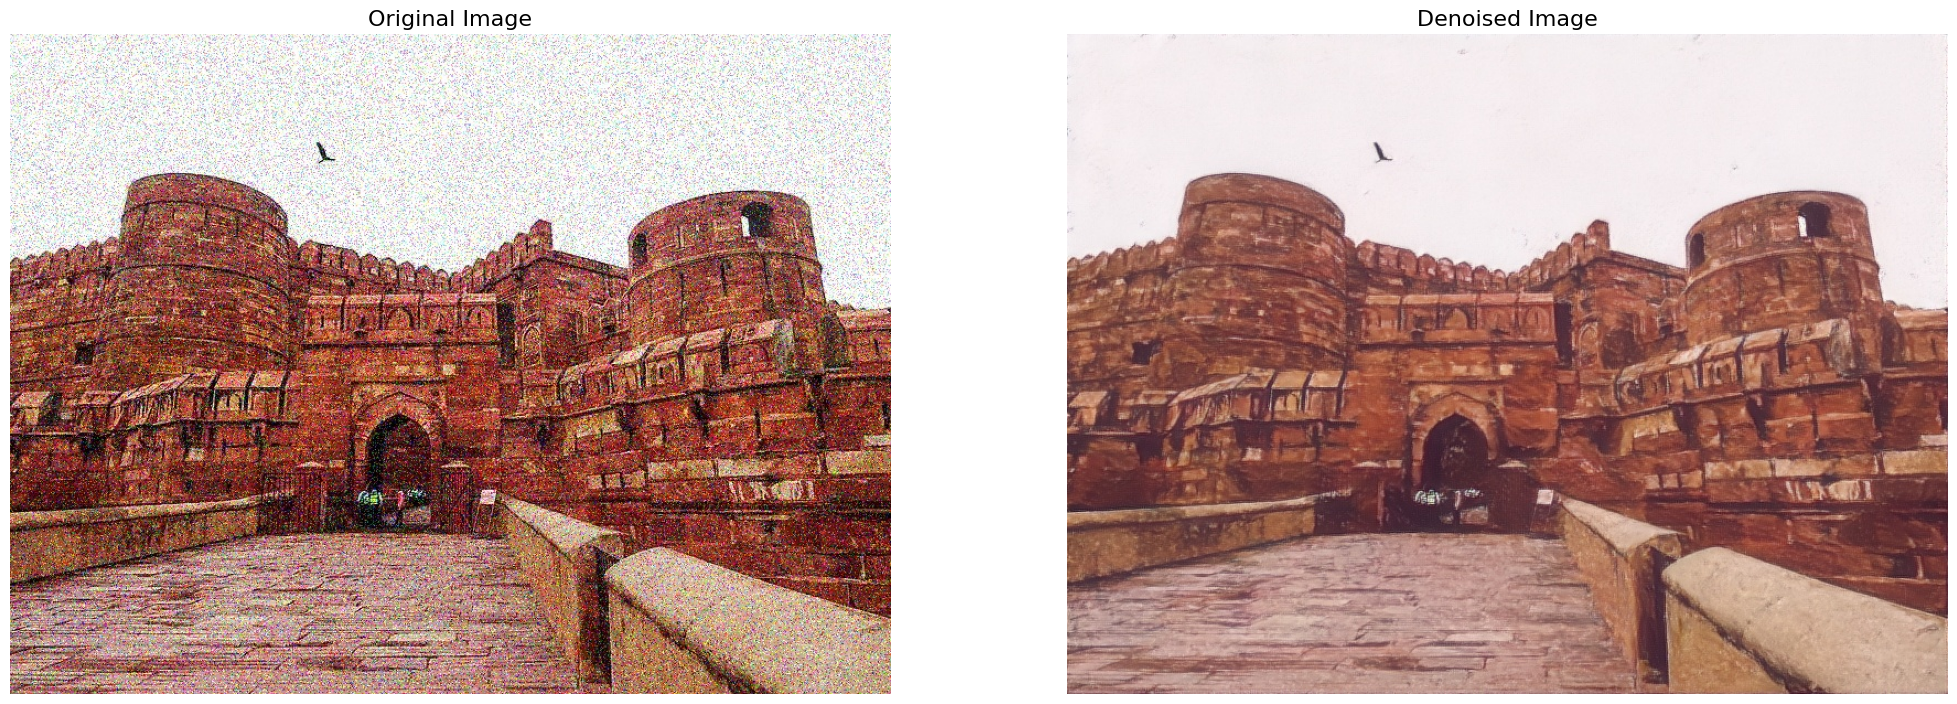

In [ ]:
# visualize
input_list = sorted(glob.glob(os.path.join(upload_folder, '*')))
output_list = sorted(glob.glob(os.path.join(result_folder, '*')))
for input_path, output_path in zip(input_list, output_list):
  img_input = imread(input_path)
  img_output = imread(output_path)
  display(img_input, img_output)

## 4. Download results

In [ ]:
# download the result
print(f'Download {result_folder}')
os.system(f'zip -r -j download.zip {result_folder}/*')
files.download("download.zip")

Download upload/output


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
 print("Accuracy for Deblur task:", accuracy["Denoise"])

Accuracy for Deblur task: 0.96
